In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

import lightgbm as lgb

### train

Training until validation scores don't improve for 200 rounds
[100]	valid_0's l2: 0.150674
Did not meet early stopping. Best iteration is:
[25]	valid_0's l2: 0.139098
0.8268156424581006
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l2: 0.148189
Did not meet early stopping. Best iteration is:
[24]	valid_0's l2: 0.145021
0.797752808988764
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l2: 0.11194
Did not meet early stopping. Best iteration is:
[81]	valid_0's l2: 0.11135
0.8820224719101124
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l2: 0.150859
Did not meet early stopping. Best iteration is:
[21]	valid_0's l2: 0.141226
0.797752808988764
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l2: 0.107627
Did not meet early stopping. Best iteration is:
[39]	valid_0's l2: 0.100877
0.8539325842696629
metrics: 0.83 ± 0.03


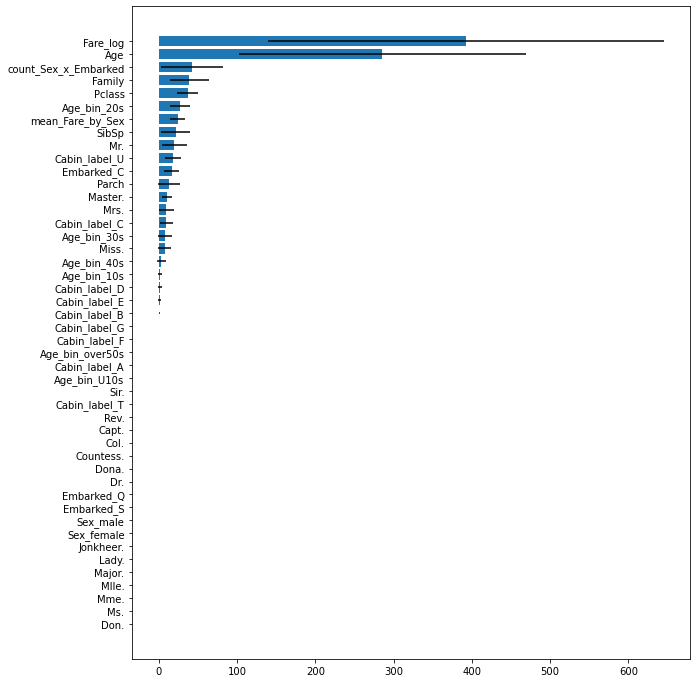

In [78]:
# データの読み込み
train = pd.read_csv('../input/processed/featured_train.csv')
test = pd.read_csv('../input/processed/featured_test.csv')

# ハイパーパラメータの設定
params = {
    'objective': 'regression',
    'random_seed': 1234,
}

# 説明変数と目的変数を指定
X_train = train.drop(['PassengerId', 'Survived', 'Name', 'Sex', 'Ticket',
                        'Fare', 'Cabin', 'Embarked', 'Age_bin', 'Cabin_label'], axis=1)
Y_train = train['Survived']

# Foldごとの結果を保存
models = []
metrics = []
imp = pd.DataFrame()

# K分割する
folds = 5
kf = KFold(n_splits=folds)

for nfold, (train_index, val_index) in enumerate(kf.split(X_train)):
    x_train = X_train.iloc[train_index]
    x_valid = X_train.iloc[val_index]
    y_train = Y_train.iloc[train_index]
    y_valid = Y_train.iloc[val_index]

    model = lgb.LGBMClassifier(**params)
    model.fit(x_train,
                y_train,
                eval_set=(x_valid, y_valid),
                early_stopping_rounds=200,
                verbose=100,
                )

    y_pred = model.predict(x_valid)
    acc = accuracy_score(y_valid, y_pred)
    print(acc)

    models.append(model)
    metrics.append(acc)

    _imp = pd.DataFrame({'col': x_train.columns, 'imp': model.feature_importances_, "nfold":nfold+1})
    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

metrics = np.array(metrics)
print(f'metrics: {np.mean(metrics):.2f} ± {np.std(metrics):.2f}')


imp = imp.groupby("col")["imp"].agg(["mean", "std"])
imp.columns = ["imp", "imp_std"]
imp = imp.reset_index(drop=False).sort_values('imp', ascending=True)

plt.figure(figsize=(10, 12))
plt.barh(imp['col'], imp['imp'], xerr=imp['imp_std'])
plt.show()

### inference

In [79]:
# 説明変数と目的変数を指定
X_test = test.drop(['PassengerId', 'Survived', 'Name', 'Sex', 'Ticket', 
                    'Fare', 'Cabin', 'Embarked', 'Age_bin', 'Cabin_label'], axis=1)

# テストデータにおける予測
preds = []

for model in models:
    pred = model.predict(X_test)
    preds.append(pred)

# アンサンブル学習
preds_array = np.array(preds)
pred = stats.mode(preds_array)[0].T # 予測データリストのうち最頻値を算出し、行と列を入れ替え

### submit

In [80]:
# 提出用ファイルの読み込み
sub = pd.read_csv('../input/titanic/gender_submission.csv')

# 目的変数カラムの置き換え
sub['Survived'] = pred.astype('int')

# ファイルのエクスポート
sub.to_csv('../submit/titanic_lgb.csv', index=False)